Name: Kanchika Sudhirkumar Kapoor

email: 10621287@mydbs.ie

### Question 1.a.answer    

Use a real-world dataset (i.e. relational, text, image, video, voice files), prepare the dataset for modelling, consider one categorical variable in the dataset, and apply the classification task. To do so:  

⦁	Provide the functional form of the predictive model for each algorithm.  
                                                                          
⦁	Train each model using different ratios of the trainset and visualize the performance of models using accuracy (y -axis) in terms of different ratio of trainsets (x-axis). Elaborate on the insights.                               

⦁	Apply ensemble methods (bagging, boosting, stacking) on the base models, evaluate the performance of each ensemble technique in 100 Monte Carlo runs and visualize the performance of models using Boxplot.                                                                                           
⦁	Select the best classifier and elaborate on its advantages and limitations.                               

In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import necessary modules

# For Data Acquistion
import spotipy
import spotipy.oauth2 as oauth2
import pandas as pd
import io
import json

# for Data Preparation and Data Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# for Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')

#### Data Acquistion:

Spotify api is being used to pull data about a user's liked and disliked tracks. 

Disliked and other playlists created by same user were used to determine liked and disliked songs for the user.

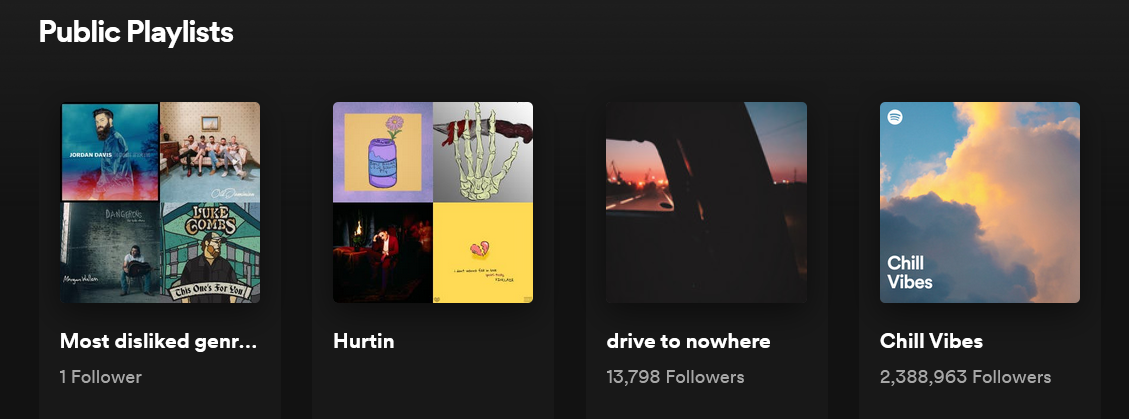

In [ ]:
def get_spotify_client(key, secret, user, scope):
  """
  create spotify client using spotify
  api credentials

  returns spotify client
  """
  # Get a token
  client_credentials_manager = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
  # Create a Spotify client
  sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
  return sp

def get_paginated_playlist_tracks(client, user, playlist_id):
  """
  each playlist call limits to 100 
  tracks per call. this method gets
  all data in tracks list

  returns list of all tracks in playlist
  """
  result = client.user_playlist_tracks(user, playlist_id)
  tracks = result['items']
  while result['next']:
      result = client.next(result)
      tracks.extend(result['items'])
  return tracks

def get_playlist_details(client, user, playlist_id):
  """
  takes spotify client and fetches playlist info
  gets tracks from playlist and pulls features for
  individual track

  returns array of song features
  """
  tracks = get_paginated_playlist_tracks(client, user, playlist_id)
  # print(json.dumps(tracks,sort_keys=True,indent=4))
  arr = []
  for i in tracks:
    track = i['track']
    track_details = {}
    track_details['artist'] = track['artists'][0]['name']
    track_details['album'] = track['album']['name']
    # Get track audio features
    track_features = client.audio_features(track['id'])[0]
    track_data = {**track_details,**track_features}
    arr.append(track_data)
  # print(arr,len(arr))
  return arr

def playlist_json_dataframe(client, user, playlist_id):
  """
  gets playlist json and converts to dataframe

  returns dataframe
  """
  get_json = get_playlist_details(client, user, playlist_id)
  df = pd.read_json(io.StringIO(json.dumps(get_json)))
  return df

# Spotify API key and secret
CLIENT_ID = "6e700f86b8a946f1a8f73ed203b09762"
CLIENT_SECRET = "a99bb010d2ac494eaafdb0821b153c58"

USERNAME = "31hyhbdc7v774wqwfreth3koxiny"
SCOPE = "user-read-currently-playing"

sp_client = get_spotify_client(CLIENT_ID, CLIENT_SECRET, USERNAME, SCOPE)

In [ ]:
DISLIKED_PLAYLIST_ID='5DF2VYqsLDNwuN4WubsBbA'
df1 = playlist_json_dataframe(sp_client, USERNAME, DISLIKED_PLAYLIST_ID)
df1['like'] = False

In [ ]:
LIKED_PLAYLIST_ID = '37i9dQZF1DX889U0CL85jj'
df2 = playlist_json_dataframe(sp_client, USERNAME, LIKED_PLAYLIST_ID)
df2['like'] = True

In [ ]:
df = pd.concat([df1, df2])
df.reset_index(drop=True, inplace=True)
df = df.drop(['id', 'type', 'track_href', 'uri', 'analysis_url'], axis=1)
df

,artist,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,like
0,Morgan Wallen,Dangerous: The Double Album,0.635,0.772,7,-4.825,1,0.0279,0.2160,0.000000,0.2850,0.948,119.017,147893,4,False
1,Luke Combs,This One's for You,0.464,0.813,10,-6.185,1,0.0416,0.0153,0.000000,0.2540,0.515,75.977,222533,4,False
2,Old Dominion,Old Dominion,0.706,0.358,6,-8.331,1,0.0347,0.6770,0.000000,0.1070,0.478,75.991,186240,4,False
3,Jordan Davis,Home State,0.523,0.837,7,-4.494,1,0.0335,0.3010,0.000000,0.1720,0.523,82.006,193929,4,False
4,Morgan Wallen,Dangerous: The Double Album,0.466,0.786,0,-5.130,1,0.0328,0.4170,0.000061,0.1250,0.571,203.903,210507,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Gaidaa,Overture,0.784,0.531,5,-7.756,1,0.0410,0.3380,0.000023,0.0996,0.188,87.982,219452,4,True
399,Bay Ledges,Ritual,0.835,0.765,5,-8.427,1,0.0328,0.2890,0.851000,0.1330,0.971,121.979,189770,4,True
400,Bobby Freemont,Doors To Kick,0.670,0.319,4,-8.569,0,0.0400,0.6380,0.413000,0.0847,0.253,92.968,206452,4,True
401,LOONY,soft thing,0.791,0.268,7,-6.417,1,0.0496,0.6600,0.000346,0.0950,0.363,122.194,167213,4,True


#### Data Exploration

Running various analysis on acquired data

Check for imbalance in dataset

False    253
True     150
Name: like, dtype: int64


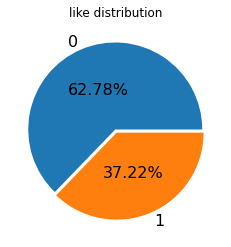

In [ ]:
print(df['like'].value_counts())
pie = plt.subplots(figsize=[4,4])
labels = [0,1]
plt.pie(x = df['like'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 16})
plt.title('like distribution')
plt.show()

From above, the data is fairly balanced.

Both album and artist columns can be used for determining the liked and disliked tracks.

We can use `LabelEncoder`to convert the values in the column instead of dropping the columns

In [ ]:
label_encoder = LabelEncoder()
df['album'] = label_encoder.fit_transform(df['album'])
df['artist'] = label_encoder.fit_transform(df['artist'])

Plot histogram for every numerical column in the dataframe

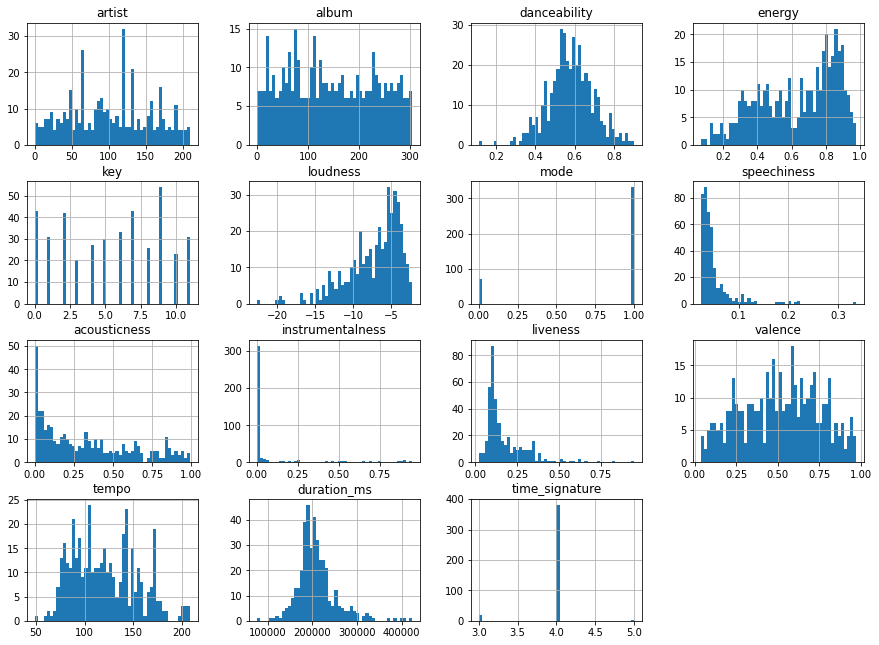

In [ ]:
df.hist(bins = 50,figsize = (15,11))
plt.show()

From the histogram above, we can observe the data distribution for various features in the dataset

Create a heatmap for understanding features correlation in the dataset. We can drop very highly correlated columns (more than ~90% correlation)

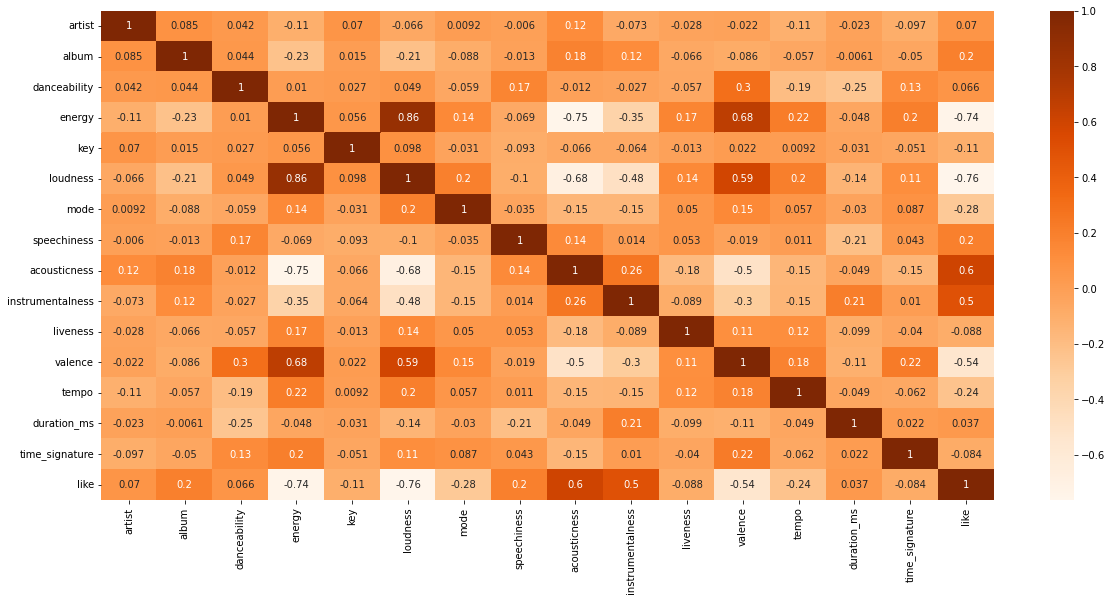

In [ ]:
plt.figure(figsize=(20,9))
sns.heatmap(df.corr(), annot=True, cmap='Oranges')
plt.show()

From the correlation map, we see observe the following:
* All features are fairly unique with no 2 columns exceeding more than 90% correlation
* loudness and valence are highly correlated to energy
* user has higher likeness for tracks with higher intrumentalness and acousticness

define method for scaling features using `StandardScalar`

In [ ]:
def scale_values(features):
  """
  scale values using StandardScalar

  returns scaled features
  """
  scaler = StandardScaler()
  return scaler.fit_transform(features)

Separate dependent and independent features and scale the data using `StandardScalar` by calling `scale_values` method defined above.

For classification, we are predicting `like` feature which corresponds to whether user likes the track or not

In [ ]:
X = df.drop('like',axis=1)
y = df['like']

X = scale_values(X)

### Q1.a. Answer

define a method that returns dictionary of various classification models

In [ ]:
def get_classification_models():
  """
  creates a dictionary of different models
  
  returns dictionary of model classes
  """
  models = {}
  models['lr'] = LogisticRegression()
  models['svm_linear'] = SVC(kernel='linear')
  models['svm_poly'] = SVC(kernel='poly')
  models['svm_rbf'] = SVC(kernel='rbf')
  models['svm_sigmoid'] = SVC(kernel='sigmoid')
  models['dt'] = DecisionTreeClassifier(random_state=42) # random_state used to get same result for every code rerun
  models['rf'] = RandomForestClassifier(n_estimators=300, random_state=42) # random_state used to get same result for every code rerun
  models['knn'] = KNeighborsClassifier(n_neighbors=5)
  return models

define method for getting various metrics from cross validation of various models

In [ ]:
def calculate_model_metrics(model_class_dict, scoring_dict):
  """
  calculates various scores using cross validation 
  for every model provided in model_class_dict param

  scoring_dict param defines different metrics to
  calculate
  """

  for i, j in model_class_dict.items():
    print('='*108)
    print('\t \t \t \t Stats for model: ', str(j))
    print('='*108)
    scores = cross_validate(j, X, y, scoring=scoring_dict, cv=5) # ,return_train_score=True)
    df_ = pd.DataFrame(scores)
    print(df_.describe().to_markdown())
    print(' ')

  return None

Using cross validation, evaluate performance of every classification models used

In [ ]:
cls_models = get_classification_models()
cls_metrics = {
                'accuracy': 'accuracy',
                'precision': 'precision',
                'f1 score': 'f1',
                'recall': 'recall'
              }

calculate_model_metrics(cls_models, cls_metrics)

	 	 	 	 Stats for model:  LogisticRegression()
|       |   fit_time |   score_time |   test_accuracy |   test_precision |   test_f1 score |   test_recall |
|:------|-----------:|-------------:|----------------:|-----------------:|----------------:|--------------:|
| count |  5         |    5         |        5        |        5         |       5         |     5         |
| mean  |  0.0396392 |    0.0208488 |        0.920586 |        0.912137  |       0.890364  |     0.88      |
| std   |  0.0148414 |    0.0119225 |        0.018777 |        0.0630775 |       0.0325151 |     0.0960324 |
| min   |  0.018291  |    0.0049727 |        0.901235 |        0.848485  |       0.846154  |     0.733333  |
| 25%   |  0.0322511 |    0.0119791 |        0.9125   |        0.852941  |       0.877193  |     0.833333  |
| 50%   |  0.041754  |    0.0254517 |        0.91358  |        0.925926  |       0.888889  |     0.933333  |
| 75%   |  0.0505092 |    0.0282919 |        0.925    |        0.933333  |       

From above, Random Forest classifier model has the highest accuracy and recall metrics making it the best model out of all classification models used

### Q1.b. Answer

define a method for training models based on various split values

In [ ]:
def train_model_various_splits(model_class, train_ratios, features, label):
  """
  get accuracy of model for a range of test ratios
  train_ratios param defines the various ratios on which
  the model needs to be trained

  returns dictionary of accuracy for every train ratio
  for a given model_class
  """
  acc = []
  for split in train_ratios:
    X_train,X_test,y_train,y_test = train_test_split(features, label, test_size=split)
    model_class.fit(X_train, y_train)
    y_pred = model_class.predict(X_test)
    acc.append((split, accuracy_score(y_test, y_pred)))
  return acc

train various models with different train test split ratios and store results in dictionary

In [ ]:
# train models on various splits

models = get_classification_models()
train_rations = np.round(np.arange(0.1,0.9,0.05), 2) # rounded to fix floating point precision
mod = {}

for m_name, m_class in models.items():
  mod[m_name] = train_model_various_splits(m_class, train_rations, X, y)

print(mod)

{'lr': [(0.1, 0.9024390243902439), (0.15, 0.9016393442622951), (0.2, 0.9382716049382716), (0.25, 0.9108910891089109), (0.3, 0.9008264462809917), (0.35, 0.9366197183098591), (0.4, 0.9074074074074074), (0.45, 0.9230769230769231), (0.5, 0.9257425742574258), (0.55, 0.9324324324324325), (0.6, 0.9297520661157025), (0.65, 0.9007633587786259), (0.7, 0.9328621908127208), (0.75, 0.9240924092409241), (0.8, 0.8885448916408669), (0.85, 0.9067055393586005)], 'svm_linear': [(0.1, 0.9024390243902439), (0.15, 0.9672131147540983), (0.2, 0.9629629629629629), (0.25, 0.8712871287128713), (0.3, 0.9504132231404959), (0.35, 0.9366197183098591), (0.4, 0.9259259259259259), (0.45, 0.9010989010989011), (0.5, 0.905940594059406), (0.55, 0.8963963963963963), (0.6, 0.9049586776859504), (0.65, 0.8931297709923665), (0.7, 0.8763250883392226), (0.75, 0.8679867986798679), (0.8, 0.8978328173374613), (0.85, 0.8775510204081632)], 'svm_poly': [(0.1, 0.975609756097561), (0.15, 0.9344262295081968), (0.2, 0.8518518518518519), (0

generate chart of accuracy against different Train Test Splits for various models using above dictionary

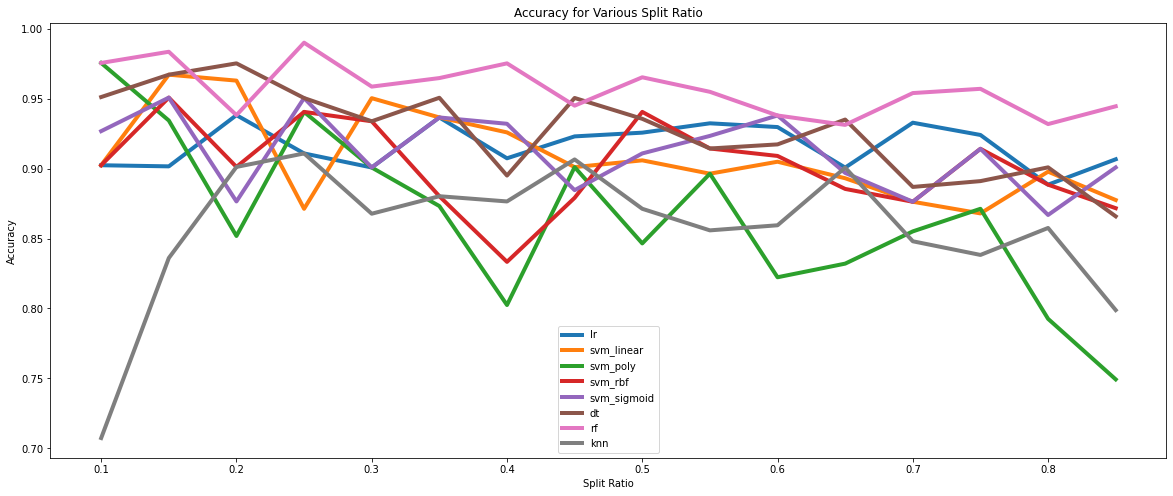

In [ ]:
plt.figure(figsize=(20,8))
for i,j in mod.items():
  plt.plot(*zip(*(j)), label = i, linewidth = 4)
  plt.ylabel('Accuracy'); plt.xlabel('Split Ratio'); plt.title('Accuracy for Various Split Ratio');

plt.legend()
plt.show()

From above, 

* Random forest has reached highest accuracy at 0.25 split ratio out of all models across all ratios
* KNN has the worst accuracy out of all models across all ratios at 0.1 split ratio
* Both, KNN and SVM with polynomial kernel models accuracy decays as the split ratio increases
* Logistic Regression has stable accuracy across all splits with little to no steep rise or decline in accuracy
* At 0.25 and 0.45 split ratios, all models has accuracy over 85%

### Q1.c. Answer

define a common method to create stacking model

In [ ]:
def get_stacking_model(level0_dict, level1, m_type='classification'):
	"""
	creates a stacking model based on level0 and level1
	models provided to the method.
	based on m_type param, provides classification or regression
	model; defaults to classification

	returns Stacking ensemble method
	"""

	level0 = []

	for i, j in level0_dict.items():
		level0.append((i , j))
	
	if m_type=='classification':
		model_class = StackingClassifier
	else:
		model_class = StackingRegressor
 
	model = model_class(estimators=level0, final_estimator=level1, cv=5)
	return model

Based on previous evaluation, Random Forest, Decision Tree and Logistic Regression were identified as best classifiers based on accuracy. 

These 3 models are used as base models for ensemble methods.

In [ ]:
def classification_ensemble_models():
  dt = cls_models['dt']
  rf = cls_models['rf']
  lr = cls_models['lr']
  models = {}
  models['dt'] = dt
  models['lr'] = lr
  models['stacking'] = get_stacking_model(models, rf) #decision tree, logistic regression - level 0 and random forest - level 1 estimators
  models['bagging_dt'] = BaggingClassifier(base_estimator=dt, n_estimators=50, max_samples=0.8, max_features=0.8)
  models['bagging_rf'] = BaggingClassifier(base_estimator=rf, n_estimators=50, max_samples=0.8, max_features=0.8)
  models['adaboost_dt'] = AdaBoostClassifier(base_estimator=dt, n_estimators=800)
  models['rf'] = rf

  return models

define method for evaluating various models using monte carlo runs

In [ ]:
def evaluate_model_monte_carlo(total_runs, model_class, random_state, test_split, features, label, scoring_function):
  """
  evaluate the performance of each model technique in n Monte Carlo runs.
  total_runs param is used for total number of runs

  returns list of prediction score
  """
  lst_score = []
  X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=test_split)
  for i in range(total_runs):
      model_class.fit(X_train,y_train)
      y_pred = model_class.predict(X_test)
      score = scoring_function(y_test, y_pred)
      lst_score.append(score)
  return lst_score

calculate accuracy score and evaluate various classification ensemble models using 100 monte carlo runs

In [ ]:
models = classification_ensemble_models()
mc_acc = []
for i,j in models.items():
  mc_acc.append(evaluate_model_monte_carlo(100, j, 42, 0.25, X, y, accuracy_score))

Plot box plot using accuracy score for every model acquired in above step

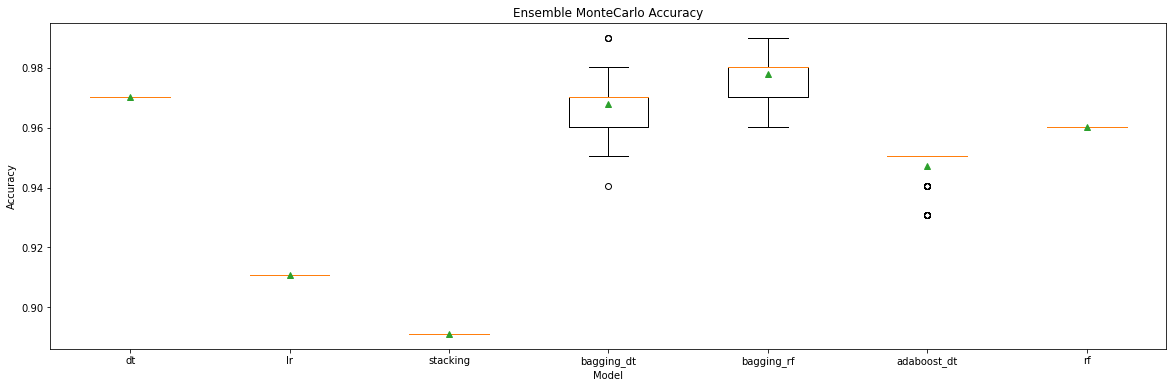

In [ ]:
plt.figure(figsize=(20,6))
plt.title("Ensemble MonteCarlo Accuracy");plt.xlabel("Model" );plt.ylabel("Accuracy");
plt.boxplot(mc_acc, labels=models.keys(), showmeans=True)
plt.show()

From above, Bagging Classifier with Random forest classifier as base estimator performs the best out of all classification models.

Bagging is an ensemble method in which multiple models are trained on different subsets of the training data and then combined to make a final prediction. The full form of "bagging" is "bootstrap aggregation" which refers to the process of sampling the training data with replacement to create the different subsets.

Random forest is a type of ensemble learning method which can be used for classification as well as regression. They operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Advantages of Bagging Classifier:

* Improved accuracy: By aggregating the predictions of multiple models, a bagging classifier can often improve the accuracy of the final prediction. This is especially true if the base classifier has high variance, as is often the case with decision trees and random forests.

* Reduced overfitting: Bagging can also help to reduce overfitting, since the individual models in the ensemble are trained on different subsets of the training data and are therefore less likely to overfit to any one particular subset.

* Parallelization: Bagging can be easily parallelized, since the individual models can be trained in parallel on different subsets of the data. This can make training faster wherein not too many estimators are needed, especially when using a base classifier that is computationally intensive.

Limitations of Bagging Classifier:

* Increased computation time: Training and predicting with a bagging classifier can be slower than with a single model, since multiple models must be trained and the predictions of all of these models must be combined.

* Reduced interpretability: Bagging classifiers can be less interpretable than a single model, since it can be difficult to understand how each individual model contributes to the final prediction. This can be a disadvantage if we need to understand why a particular prediction was made.





### Q2. Answer

We can use the same acquired spotify dataset with prediction on `danceability` feature of the song.

Also, some of the utility functions defined above can be reused for this solution as well

In [ ]:
# import regression models
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# import metric
from sklearn.metrics import mean_squared_error

Outliers detected in speechiness column are imputed using upper_whisker

In [ ]:
def outlier_detect_impute(col_name, dataframe):
  """
  calculate upper whisker and lower whisker using
  tuckey's formula to find outliers in a given 
  column of a dataframe.
  Impute outliers with upper_whisker value

  returns column data
  """
  data = dataframe.sort_values(by = [col_name])
  q1 = dataframe[col_name].quantile(0.25)
  q3 = dataframe[col_name].quantile(0.75)
  iqr = q3-q1
  lower_whisker = q1-1.5*iqr
  upper_whisker = q3+1.5*iqr
  dataframe.loc[dataframe[col_name]>upper_whisker, col_name] = upper_whisker
  dataframe = dataframe.sort_index().reset_index(drop = True)
  return dataframe[col_name]


df['speechiness']=outlier_detect_impute('speechiness', df)

Use `danceability` feature as label for regression and scale features using `StandardScalar` by calling `scale_values` method defined before

In [ ]:
X = df.drop('danceability',axis=1)
y = df['danceability']

X = scale_values(X)

Define Regression Models to use


In [ ]:
def get_regression_models():
  """
  returns a dictionary of regression models
  """
  models = {}
  models['linear'] = LinearRegression()
  models['svr_linear'] = SVR(kernel='linear')
  models['svr_poly'] = SVR(kernel='poly')
  models['svr'] = SVR()
  models['svr_sigmoid'] = SVR(kernel='sigmoid')
  models['dt_sq_error'] = DecisionTreeRegressor(criterion='squared_error', random_state=42) #random state used for metrics consistency
  models['dt_abs_error'] = DecisionTreeRegressor(criterion='absolute_error', random_state=42) #random state used for metrics consistency
  models['dt_poisson'] = DecisionTreeRegressor(criterion='poisson', random_state=42) #random state used for metrics consistency
  models['rf'] = RandomForestRegressor(n_estimators = 10, random_state=42) #random state used for metrics consistency
  models['rf_abs_error'] = RandomForestRegressor(n_estimators = 10, criterion='absolute_error', random_state=42) #random state used for metrics consistency
  models['knn'] = KNeighborsRegressor()
  return models

get various metrics for each regression model using cross validation

In [ ]:
regression_models = get_regression_models()

regression_score = {
    'explained_variance': 'explained_variance',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2_score': 'r2',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

calculate_model_metrics(regression_models, regression_score)

	 	 	 	 Stats for model:  LinearRegression()
|       |    fit_time |   score_time |   test_explained_variance |   test_neg_mean_absolute_error |   test_r2_score |   test_neg_root_mean_squared_error |
|:------|------------:|-------------:|--------------------------:|-------------------------------:|----------------:|-----------------------------------:|
| count | 5           |  5           |                 5         |                      5         |       5         |                          5         |
| mean  | 0.00146642  |  0.00137496  |                 0.163159  |                     -0.0805093 |       0.130864  |                         -0.103148  |
| std   | 0.000621681 |  0.000456564 |                 0.0865711 |                      0.0187029 |       0.0714889 |                          0.023672  |
| min   | 0.00096941  |  0.00103331  |                 0.0680814 |                     -0.10101   |       0.0535122 |                         -0.134367  |
| 25%   | 0.00103951  |  

With a low nrmse and highest r2 score out of all regression models used, Random Forest regressor with default `absolute_error` criterion is the best estimator in this case.

Based on previous evaluation, Random forest regressor with criterion `squared_error` and `absolute_error` and SVR were identified as best regressors based on nrmse and r2 score

These 3 models are picked to use with regression ensemble methods


In [ ]:
def regression_ensemble_models():
  """
  returns a dictionary of regression
  ensemble models
  """
  svr = regression_models['svr']
  rf = regression_models['rf']
  rf_abs_error = regression_models['rf_abs_error']
  models = {}
  models['svr'] = svr
  models['rf'] = rf
  models['stacking'] = get_stacking_model(models, rf_abs_error, 'regression') #rf, svr - level 0 and random forest rf_abs_error - level 1 estimators
  models['bagging_svr'] = BaggingRegressor(base_estimator=svr, n_estimators=50, max_samples=0.8, max_features=0.8)
  models['bagging_rf'] = BaggingRegressor(base_estimator=rf, n_estimators=50, max_samples=0.8, max_features=0.8)
  models['adaboost_svr'] = AdaBoostRegressor(base_estimator=svr, n_estimators=800)
  models['gradientboost'] = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
  models['rf_abs_error'] = rf_abs_error


  return models

Evaluate all regression based ensemble models using rmse score calculated with 100 monte carlo runs

In [ ]:
models = regression_ensemble_models()
rmse_arr = []
for i,j in models.items():
  rmse_arr.append(np.sqrt(evaluate_model_monte_carlo(100, j, 42, 0.35, X, y, mean_squared_error)))

Plot box plot using rmse score for all ensemble models

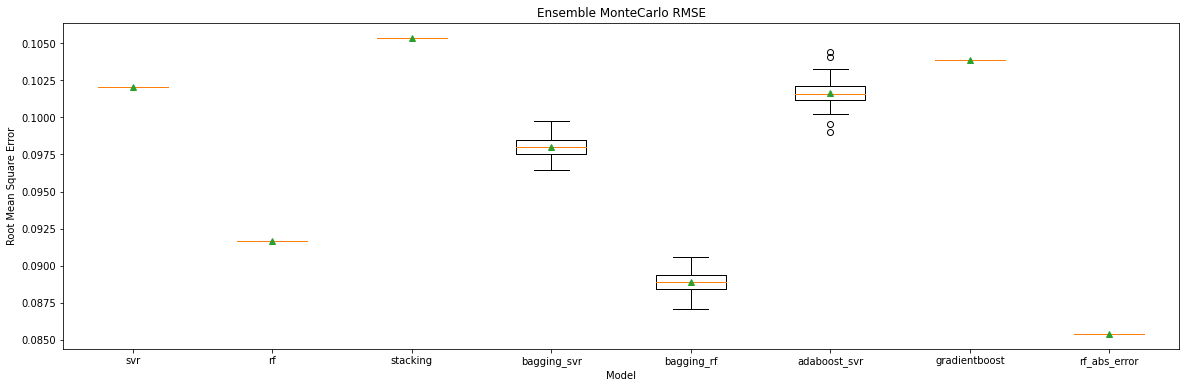

In [ ]:
plt.figure(figsize=(20,6))
plt.title("Ensemble MonteCarlo RMSE");plt.xlabel("Model" );plt.ylabel("Root Mean Square Error");
plt.boxplot(rmse_arr, labels=models.keys(), showmeans=True)
plt.show()

From above with low rmse, random forest regressor with `absolute_error` criterion is the best model for predicting danceability of the track in playlist